# Notebook for final analysis

## Import necessary libraries

In [1]:
import pandas as pd
from data.data_functions import *
from simulation.simulation_models import *
from optimization.optimization import *

## Henter nødvendige dataset

### Timesbasert data historisk

In [2]:
fin_hf_med_path = "./data/med_pasientstrøm_time_2024.xlsx"
fin_hf_kir_path = "./data/kir_pasientstrøm_time_2024.xlsx"

fin_data_hourly = create_hourly_dataframe(fin_hf_med_path, fin_hf_kir_path)



fin_data_hourly["Belegg"] = fin_data_hourly.apply(calculate_patients, axis=1)
fin_data_hourly["skift_type"] = fin_data_hourly.apply(add_shift_type, axis=1)

fin_data_hourly.head(10)

,År,Måned,Uke,Dag,DatoTid,Timer,post,helg,Antall inn på post,Antall pasienter ut av Post,Belegg,skift_type
0,2024,January,1,Monday,2024-01-01 00:00:00,0,medisinsk,0,2.0,0.0,2.0,natt
1,2024,January,1,Monday,2024-01-01 00:00:00,0,kirurgisk,0,0.0,0.0,2.0,natt
2,2024,January,1,Monday,2024-01-01 01:00:00,1,medisinsk,0,0.0,0.0,2.0,natt
3,2024,January,1,Monday,2024-01-01 01:00:00,1,kirurgisk,0,0.0,0.0,2.0,natt
4,2024,January,1,Monday,2024-01-01 02:00:00,2,kirurgisk,0,0.0,0.0,2.0,natt
5,2024,January,1,Monday,2024-01-01 02:00:00,2,medisinsk,0,0.0,0.0,2.0,natt
6,2024,January,1,Monday,2024-01-01 03:00:00,3,kirurgisk,0,0.0,0.0,2.0,natt
7,2024,January,1,Monday,2024-01-01 03:00:00,3,medisinsk,0,1.0,0.0,3.0,natt
8,2024,January,1,Monday,2024-01-01 04:00:00,4,kirurgisk,0,0.0,0.0,3.0,natt
9,2024,January,1,Monday,2024-01-01 04:00:00,4,medisinsk,0,1.0,0.0,4.0,natt


### Timesbasert prediksjoner

In [3]:
fin_data_hourly_med = fin_data_hourly[fin_data_hourly["post"]=="medisinsk"]
fin_data_hourly_kir = fin_data_hourly[fin_data_hourly["post"]=="kirurgisk"]

next_year_med = create_forecast_hourly(fin_data_hourly_med, "medisinsk")
next_year_kir = create_forecast_hourly(fin_data_hourly_kir, "kirurgisk")

next_year = pd.concat([next_year_med, next_year_kir], axis=0).sort_values("DatoTid").reset_index()
next_year.drop(["index"], axis=1, inplace=True)
next_year["skift_type"] = next_year.apply(add_shift_type, axis=1)

fin_data_hourly["Prediksjoner pasientstrøm"] = np.nan
fin_data_hourly["Prediksjoner belegg"] = np.nan

fin_data_hourly = pd.concat([fin_data_hourly, next_year], axis=0).sort_values("DatoTid").reset_index()
fin_data_hourly.drop(["index"], axis=1, inplace=True)
fin_data_hourly

,År,Måned,Uke,Dag,DatoTid,Timer,post,helg,Antall inn på post,Antall pasienter ut av Post,Belegg,skift_type,Prediksjoner pasientstrøm,Prediksjoner belegg
0,2024,January,1,Monday,2024-01-01 00:00:00,0,medisinsk,0,2.0,0.0,2.0,natt,NaN,NaN
1,2024,January,1,Monday,2024-01-01 00:00:00,0,kirurgisk,0,0.0,0.0,2.0,natt,NaN,NaN
2,2024,January,1,Monday,2024-01-01 01:00:00,1,medisinsk,0,0.0,0.0,2.0,natt,NaN,NaN
3,2024,January,1,Monday,2024-01-01 01:00:00,1,kirurgisk,0,0.0,0.0,2.0,natt,NaN,NaN
4,2024,January,1,Monday,2024-01-01 02:00:00,2,kirurgisk,0,0.0,0.0,2.0,natt,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27597,2025,October,42,Tuesday,2025-10-14 22:00:00,22,medisinsk,0,NaN,NaN,NaN,kveld,0.0,24.0
27598,2025,October,42,Tuesday,2025-10-14 23:00:00,23,kirurgisk,0,NaN,NaN,NaN,natt,0.0,24.0
27599,2025,October,42,Tuesday,2025-10-14 23:00:00,23,medisinsk,0,NaN,NaN,NaN,natt,0.0,25.0
27600,2025,October,42,Wednesday,2025-10-15 00:00:00,0,medisinsk,0,NaN,NaN,NaN,natt,1.0,1.0


### Historisk data daglig aggregering

In [4]:
path = "./data/fin_hf_datagrunnlag.xlsx"
fin_data_hist = datalast_behandling(path)
fin_data_hist.head(10)

,År,Måned,Dato,Antall inn på post,Antall pasienter ut av Post,Belegg,Antall liggedogn,Senger normert,Beleggsprosent,Gjennomsnitts belegg,Antall senger i bruk,post,helg
0,2022,januar,2022-01-01,3,3,22.291667,22,33,0.675505,22.291667,33,medisinsk,1
1,2022,januar,2022-01-01,2,0,12.625000,12,22,0.742647,12.625000,17,kirurgisk,1
2,2022,januar,2022-01-02,10,6,25.416667,23,33,0.770202,25.416667,33,medisinsk,1
3,2022,januar,2022-01-02,5,3,14.625000,13,22,0.860294,14.625000,17,kirurgisk,1
4,2022,januar,2022-01-03,5,3,27.916667,27,33,0.845960,27.916667,33,medisinsk,0
5,2022,januar,2022-01-03,7,4,16.166667,16,22,0.734848,16.166667,22,kirurgisk,0
6,2022,januar,2022-01-04,11,6,28.583333,27,33,0.866162,28.583333,33,medisinsk,0
7,2022,januar,2022-01-04,4,4,18.458333,17,22,0.839015,18.458333,22,kirurgisk,0
8,2022,januar,2022-01-05,12,20,32.250000,33,33,0.977273,32.250000,33,medisinsk,0
9,2022,januar,2022-01-05,12,10,20.541667,18,22,0.933712,20.541667,22,kirurgisk,0


### Predikerte data daglig aggregering

In [5]:
path_pred = "./forecasting/excel_models/fin_hf_prediksjoner.xlsx"
sheetname_med = "hammerfest_medisinsk"
sheetname_kir = "hammerfest_kirurgisk"
forecasted_demand = create_forecast_dataset(path_pred, sheetname_med, sheetname_kir)

fin_data = pd.concat([fin_data_hist, forecasted_demand], axis=0).sort_values("Dato").reset_index()
fin_data.drop(["index"], axis=1, inplace=True)
fin_data

,År,Måned,Dato,Antall inn på post,Antall pasienter ut av Post,Belegg,Antall liggedogn,Senger normert,Beleggsprosent,Gjennomsnitts belegg,Antall senger i bruk,post,helg,Prediksjoner pasientstrøm,Prediksjoner belegg
0,2022,januar,2022-01-01,3.0,3.0,22.291667,22.0,33.0,0.675505,22.291667,33.0,medisinsk,1,NaN,NaN
1,2022,januar,2022-01-01,2.0,0.0,12.625000,12.0,22.0,0.742647,12.625000,17.0,kirurgisk,1,NaN,NaN
2,2022,januar,2022-01-02,10.0,6.0,25.416667,23.0,33.0,0.770202,25.416667,33.0,medisinsk,1,NaN,NaN
3,2022,januar,2022-01-02,5.0,3.0,14.625000,13.0,22.0,0.860294,14.625000,17.0,kirurgisk,1,NaN,NaN
4,2022,januar,2022-01-03,5.0,3.0,27.916667,27.0,33.0,0.845960,27.916667,33.0,medisinsk,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,2025,12,2025-12-29,8.0,NaN,23.000000,NaN,NaN,NaN,NaN,NaN,medisinsk,0,8.0,25.0
2881,2025,12,2025-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kirurgisk,0,4.0,14.0
2882,2025,12,2025-12-30,7.0,NaN,22.000000,NaN,NaN,NaN,NaN,NaN,medisinsk,0,8.0,24.0
2883,2025,12,2025-12-31,6.0,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,medisinsk,0,7.0,22.0


### Setter felles parametere

In [6]:
data = fin_data_hourly
post = "medisinsk"
weekend = False
predictions = False
year = 2024
avg_length_of_stay = 3  # Gjennomsnittlig liggetid (dager)
shifts_per_day = 3  # Antall skift per dag
iterations = 1000  # Antall simuleringer
month = ["May", "June", "July", "August", "September", "October"]
shift_type = "dag"
scenario = None
total_beds = 26 # 26 hvis ukedag eller helg med, kir: hverdag = 22, helg = 17
curr_sit = 12
# Med post: hverdag: dag: 12, kveld: 12, natt:4 
# Med post: Helg: 9, 9, 4
# Kir post: Hverdag: 10, 8, 3
# Kir post: Helg: 8, 7, 3

# Tilbudsiden

## Optimeringsmodell for optimalt bemanningsnivå

### Optimaliseringsdata, Modellbygging & Resultater

In [7]:
data_opt = opt_dataset(dataset=data, post=post, year=year, shift_type=shift_type, month=month, weekend=weekend, predictions=predictions)
data_opt.head(10)

# Parameters for specific model
df_index = data_opt.DatoTid
demand = data_opt["Antall inn på post"] + round(data_opt["Belegg"])
MaxStaff = 15
PPS = 3
availability = 100
ServiceLevel = 0.8
night = False

## Scenarioer: 1) Helligdager og offentlige eventer, 2) Høytider, 3) Ulykke, 4) Krig
# Her må det legges til endring i pasientstrøm og belegg pr. dag i functionene direkte, pluss endring i MaxStaff, PPS, availability og service_level
# for å simulere de ulike scenarioene 

model = labor_scheduling(df_index, demand, MaxStaff, PPS, availability, ServiceLevel, night)
result, status, obj, staff_allocated = optimize_staffing(model)
data_opt["staff_allocated"] = staff_allocated
display(data_opt) 

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\Consumer\AppData\Local\Temp\tmpbh15t_4t.glpk.raw --wglp
 C:\Users\Consumer\AppData\Local\Temp\tmpalztkwmr.glpk.glp --cpxlp C:\Users\Consumer\AppData\Local\Temp\tmpl56_3iwd.pyomo.lp
Reading problem data from 'C:\Users\Consumer\AppData\Local\Temp\tmpl56_3iwd.pyomo.lp'...
2856 rows, 952 columns, 2856 non-zeros
952 integer variables, none of which are binary
14290 lines were read
Writing problem data to 'C:\Users\Consumer\AppData\Local\Temp\tmpalztkwmr.glpk.glp'...
11427 lines were written
GLPK Integer Optimizer 5.0
2856 rows, 952 columns, 2856 non-zeros
952 integer variables, none of which are binary
Preprocessing...
Objective value =   7.132000000e+03
INTEGER OPTIMAL SOLUTION FOUND BY MIP PREPROCESSOR
Time used:   0.0 secs
Memory used: 1.4 Mb (1486356 bytes)
Writing MIP solution to 'C:\Users\Consumer\AppData\Local\Temp\tmpbh15t_4t.glpk.raw'...
3817 lines were written


,DatoTid,Antall inn på post,Belegg,staff_allocated
0,2024-05-01 07:00:00,1.0,19.0,6.0
1,2024-05-01 08:00:00,0.0,19.0,6.0
2,2024-05-01 09:00:00,0.0,20.0,6.0
3,2024-05-01 10:00:00,0.0,20.0,6.0
4,2024-05-01 11:00:00,0.0,20.0,6.0
...,...,...,...,...
947,2024-10-14 10:00:00,1.0,20.0,6.0
948,2024-10-14 11:00:00,0.0,21.0,6.0
949,2024-10-14 12:00:00,0.0,22.0,6.0
950,2024-10-14 13:00:00,0.0,22.0,6.0


### Visualize results

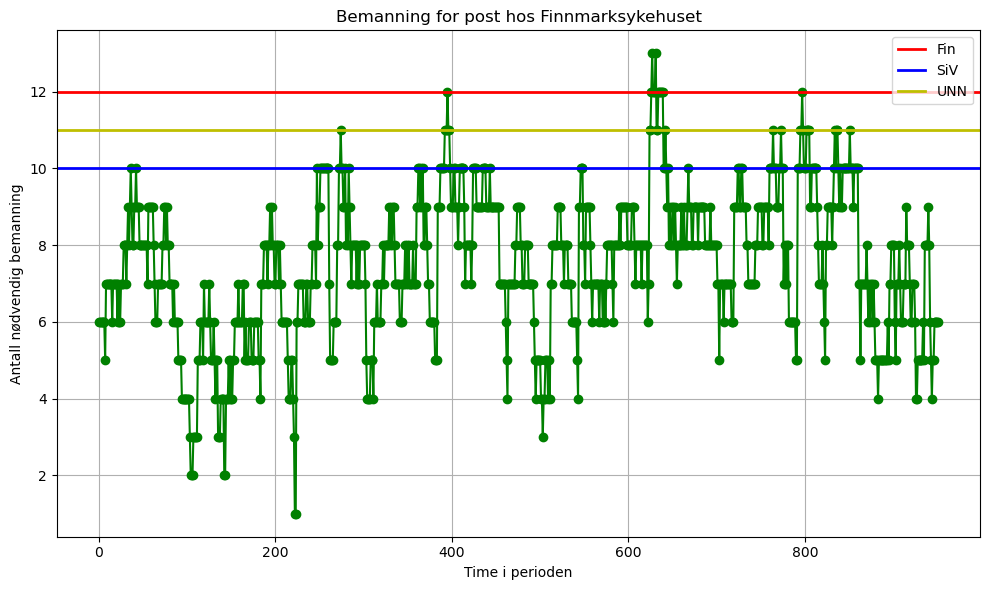

In [8]:
# Med post: hverdag: dag: 12, kveld: 12, natt:4 
# Med post: Helg: 9, 9, 4
# Kir post: Hverdag: 10, 8, 3
# Kir post: Helg: 8, 7, 3
fin = 12

# Med post: hverdag: dag: 10, kveld: 7, natt:4 
# Med post: Helg: 9, 7, 4
# Kir post: Hverdag: 10, 8, 4
# Kir post: Helg: 8, 8, 3
siv = 10

# Med post: hverdag: dag: 16, kveld: 9, natt:6 
# Med post: Helg: ?, ?, ?
# Kir post: Hverdag: 18, 11, 5
# Kir post: Helg: ?, ?, ?
unn = 11
staff_opt_plot(staff_allocated, fin, siv, unn)

## Simulering Skiftdesign for Over- og Underbemanninger

### Input data

In [9]:
# Parameter for specific model
staff_needed = data_opt["staff_allocated"]
staff_needed = pd.Series(staff_needed)

## Scenarioer: 1) Helligdager og offentlige eventer, 2) Høytider, 3) Ulykke, 4) Krig, 5) evt. to shift helg istedet for 3 (?)
# Her må det legges til endring i pasientstrøm og belegg pr. dag i functionene direkte, pluss endring i MaxStaff, PPS, availability og service_level (fra optimeringsdelen),
# og avg_length_of_stay, (shifts_per_day) for å simulere de ulike scenarioene  

### Simulering under/overbemannede skift

In [10]:
understaffed_shifts, overstaffed_shifts, total_shifts, staffed_shifts_data = over_under_staffed_shifts(data=data,
                                                                                                       staff_needed= staff_needed, 
                                                                                                       avg_length_of_stay= avg_length_of_stay, 
                                                                                                       shifts_per_day= shifts_per_day, 
                                                                                                       iterations= iterations, 
                                                                                                       post=post, 
                                                                                                       weekend=weekend, 
                                                                                                       predictions=predictions, 
                                                                                                       year=year,
                                                                                                       month=month,
                                                                                                       shift_type=shift_type,
                                                                                                       curr_sit = curr_sit)


prosent_underbemannet_skift = understaffed_shifts / total_shifts * 100
prosent_overbemannet_skift = overstaffed_shifts / total_shifts * 100

# Resultat: Hvor ofte er skift underbemannet?
print(f"Prosentandel timer med underbemanning: {prosent_underbemannet_skift:.2f}%")
print(f"Prosentandel timer med overbemanning: {prosent_overbemannet_skift:.2f}%")
print(f"Prosentandel timer med riktig bemanning: {(100 - (prosent_underbemannet_skift + prosent_overbemannet_skift)):.2f}%")

Prosentandel timer med underbemanning: 0.21%
Prosentandel timer med overbemanning: 98.53%
Prosentandel timer med riktig bemanning: 1.26%


### Visualiserte resultater

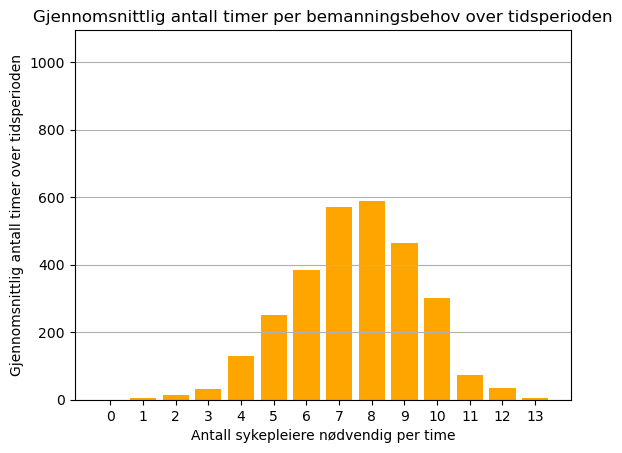

In [11]:
under_over_staffing_plot(staffed_shifts_data, iterations, shifts_per_day)

# Etterspørselsiden

## Monte Carlo Simulering Overbelastning, Belegg, og Ventetid

### Input data

In [12]:
# Model-specific parameters
data = fin_data

## Scenarioer: 1) Helligdager og offentlige eventer, 2) Høytider, 3) Ulykke, 4) Krig
# Her må det legges til endring i pasientstrøm og belegg pr. dag i functionene direkte, pluss endring i MaxStaff, PPS, availability og service_level (fra optimeringsdelen),
# total_beds, og average_stay for å simulere de ulike scenarioene  

### Simuleringsresultater

In [13]:
data, avg_overload_days, avg_occupancy_percentage, waiting_probability, all_overload_days, all_occupancy_percents = monte_carlo_simulation(data=data, 
                                                                                                                                           total_beds=total_beds, 
                                                                                                                                           average_stay= avg_length_of_stay, 
                                                                                                                                           num_simulations= iterations, 
                                                                                                                                           post= post, 
                                                                                                                                           year= year)

# Print resultater
print(f"Gjennomsnittlig antall dager med overbelastning per år: {avg_overload_days:.2f} dager")
print(f"Gjennomsnittlig beleggsprosent over året: {avg_occupancy_percentage:.2f}%")
print(f"Sannsynligheten for at pasienter må vente på en seng: {waiting_probability:.2%}")

Gjennomsnittlig antall dager med overbelastning per år: 48.08 dager
Gjennomsnittlig beleggsprosent over året: 83.88%
Sannsynligheten for at pasienter må vente på en seng: 7.36%


### Visualiserte resultater

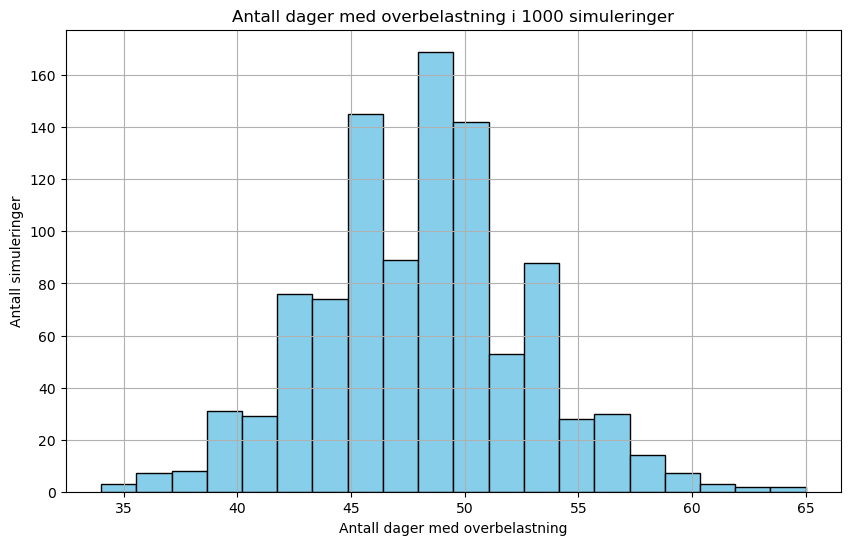

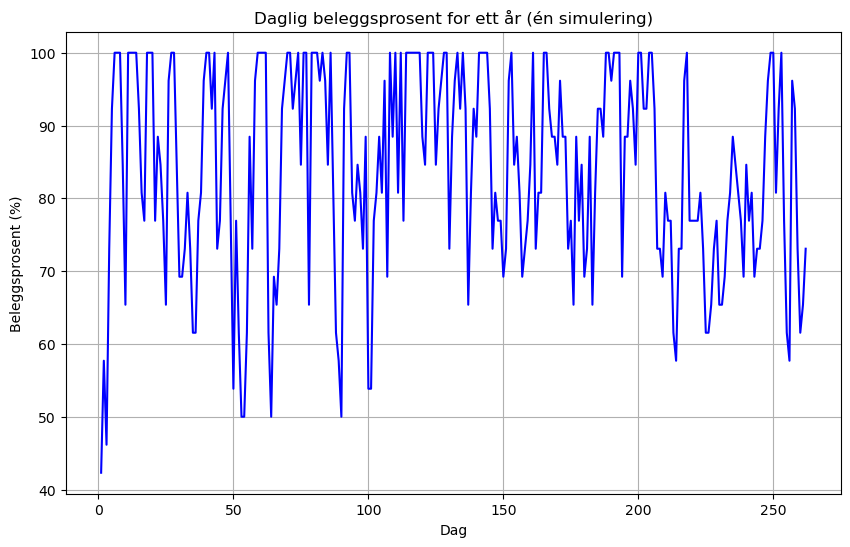

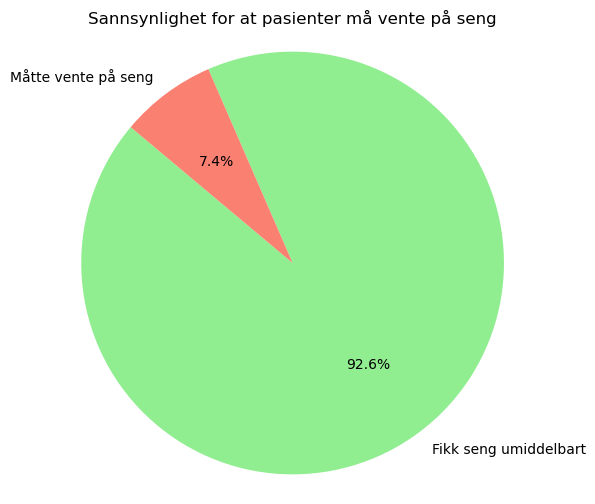

In [14]:
monte_carlo_dager_overbelastning(all_overload_days)
monte_carlo_beleggsprosent(data, all_occupancy_percents)
monte_carlo_waiting_probability(waiting_probability)